# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

## Dataset
Our dataset (Kuzishiji-49 or KMNIST) already puts our data as numpy arrays, in a compressed `npz` format.

In [43]:
# load compressed numpy arrays
dataset = "kmnist" # options are k49 or kmnist

# train images
with np.load(f'./datasets/{dataset}-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load(f'./datasets/{dataset}-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load(f'./datasets/{dataset}-test-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load(f'./datasets/{dataset}-test-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [44]:
Y_val[:10]

array([2, 9, 3, 8, 3, 3, 8, 3, 2, 5], dtype=uint8)

In [45]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv(f'./datasets/{dataset}_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [46]:
label_to_char(Y_val[:10])

2    す
9    を
3    つ
8    れ
3    つ
3    つ
8    れ
3    つ
2    す
5    は
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [47]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 60000
# of validation instances: 10000
Total # of instances: 70000


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


Instead of having features in the shape of (28, 28), let's reshape our features to (784,) so that we can easily manipulate these arrays.

In [48]:
X_tr.shape

(60000, 28, 28)

In [49]:
X_tr = X_tr.reshape((X_tr.shape[0], 28*28))
X_tr.shape

(60000, 784)

In [50]:
X_val.shape

(10000, 28, 28)

In [51]:
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_val.shape

(10000, 784)

We'll also make a helper function to display a given sample

In [69]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

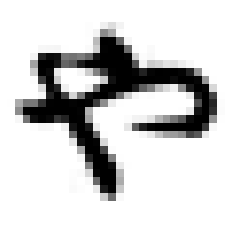

In [78]:
display_sample(X_tr[1])

## Preprocessing

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [55]:
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)

In [56]:
# scaler.fit(X_val)
X_val_scaled = scaler.transform(X_val)

In [57]:
X_tr_scaled.shape

(60000, 784)

In [58]:
X_tr_scaled[0][:25]

array([-0.048874  , -0.07068155, -0.09044445, -0.11705515, -0.15074494,
       -0.19160088, -0.234532  , -0.2829181 , -0.13461748, -0.25769268,
        3.23027834,  0.77484398, -0.5144033 , -0.53122308, -0.07607864,
        1.01300055, -0.39067629, -0.32422444, -0.27713853, -0.24852517,
       -0.22404558, -0.1964508 , -0.16753   , -0.13564714, -0.10334629])

## Naive Bayes

In [59]:
# import NaiveBayes from sklearn 
from sklearn.naive_bayes import CategoricalNB
kzsj_nb = CategoricalNB()

In [60]:
kzsj_nb.fit(X_tr_scaled, Y_tr)

CategoricalNB()

In [61]:
y_pred = kzsj_nb.predict(X_val_scaled)
y_pred[:10]

array([2, 2, 3, 0, 3, 1, 3, 2, 9, 5], dtype=uint8)

In [62]:
Y_val[:10]

array([2, 9, 3, 8, 3, 3, 8, 3, 2, 5], dtype=uint8)

In [66]:
print(classification_report(y_pred, Y_val, labels=[i for i in range(len(lookup_df))]))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       803
           1       0.52      0.51      0.52      1009
           2       0.56      0.28      0.37      2024
           3       0.62      0.62      0.62       997
           4       0.50      0.49      0.49      1037
           5       0.24      0.41      0.31       595
           6       0.55      0.56      0.55       979
           7       0.41      0.69      0.52       596
           8       0.50      0.45      0.47      1106
           9       0.46      0.54      0.50       854

    accuracy                           0.50     10000
   macro avg       0.50      0.54      0.51     10000
weighted avg       0.52      0.50      0.50     10000

